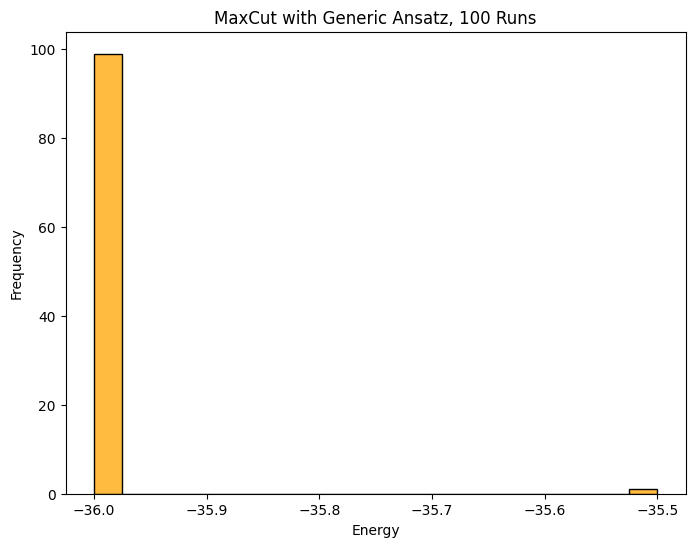

Lowest energy achieved: -35.999991


In [46]:
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter, ParameterVector
from qiskit.quantum_info import SparsePauliOp, Pauli
import networkx as nx
import numpy as np
from scipy.optimize import minimize
from qiskit.primitives import Estimator
import time
from concurrent.futures import ThreadPoolExecutor, as_completed
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)

# Custom Ansatz
def custom_ansatz(num_qubits):
    qc = QuantumCircuit(num_qubits)
    theta = ParameterVector('θ', num_qubits)
    for i in range(num_qubits):
        qc.ry(theta[i], i)
    for i in range(num_qubits - 1):
        qc.cx(i, i + 1)
    qc.cx(num_qubits - 1, 0)
    return qc, theta

def maxcut_hamiltonian(graph, num_qubits):
    """Generate the MaxCut Hamiltonian for a given graph."""
    paulis = []
    coeffs = []
    
    # Generate terms for the Hamiltonian
    for u, v in graph.edges:
        # Add -1/2 * Z_u Z_v term
        pauli_str = ['I'] * num_qubits
        pauli_str[u] = 'Z'
        pauli_str[v] = 'Z'
        paulis.append(Pauli("".join(pauli_str)))
        coeffs.append(0.5)
        
        #Add +1/2 term (identity operator)
        paulis.append(Pauli("I" * num_qubits))
        coeffs.append(-0.5)
    
    return SparsePauliOp(paulis, coeffs)

# Cost Function
def cost_function(params, hamiltonian, num_qubits):
    qc, theta = custom_ansatz(num_qubits)
    param_dict = {theta[i]: params[i] for i in range(num_qubits)}
    bound_circuit = qc.assign_parameters(param_dict)
    estimator = Estimator()
    result = estimator.run(bound_circuit, hamiltonian).result()
    return result.values[0]

# Optimization Loop with Timeout
def optimization_loop_with_timeout(hamiltonian, num_qubits, optimizer, initial_params, timeout=30):
    start_time = time.time()

    def cost(params):
        return cost_function(params, hamiltonian, num_qubits)

    result = None
    try:
        result = minimize(
            cost,
            initial_params,
            method=optimizer,
            options={'maxiter': 1000, 'tol': 1e-2},
            callback=lambda xk: (time.time() - start_time) < timeout,
        )
    except Exception as e:
        print(f"Optimization failed: {e}")

    if result and result.success:
        final_energy = cost_function(result.x, hamiltonian, num_qubits)
        return final_energy, result.x
    else:
        return None, None

# Parallel Optimization Runs
def run_multiple_optimizations_parallel(num_runs, hamiltonian, num_qubits, optimizer, timeout=30):
    energies = []
    with ThreadPoolExecutor() as executor:
        futures = [
            executor.submit(
                optimization_loop_with_timeout,
                hamiltonian,
                num_qubits,
                optimizer,
                np.random.uniform(0, 2*np.pi, num_qubits),  # Adjusted parameter range
                timeout,
            )
            for _ in range(num_runs)
        ]
        for future in as_completed(futures):
            optimal_value, _ = future.result()
            if optimal_value is not None:
                energies.append(optimal_value)
    return energies

# Problem Setup
num_qubits = 12
graph = nx.complete_graph(num_qubits)
hamiltonian = maxcut_hamiltonian(graph, num_qubits)
optimizer = 'COBYLA'
num_runs = 100
timeout = 30

# Perform Parallel Optimization
energies = run_multiple_optimizations_parallel(num_runs, hamiltonian, num_qubits, optimizer, timeout)

# Plot Results
plt.figure(figsize=(8, 6))
sns.histplot(energies, kde=False, bins=20, color='orange')
plt.title('MaxCut with Generic Ansatz, 100 Runs')
plt.xlabel('Energy')
plt.ylabel('Frequency')
plt.show()

# Print Best Energy
if energies:
    print(f'Lowest energy achieved: {min(energies):.6f}')
else:
    print("No successful optimizations.")
